In [1]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
import pandas as pd


import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA, ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX


from math import sqrt

import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
import seaborn as sns

from random import random

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_squared_log_error

In [2]:
goldprice = pd.read_csv("/content/drive/MyDrive/GoldPrice.csv")

In [3]:
headers = ['Date', 'Price', 'Open', 'High', 'Low', 'Chg%']
parse_dates = ['Date']

In [4]:
goldprice

,Date,Price,Open,High,Low,Chg%
0,"Sep 11, 2020",1957.35,1952.55,1963.3,1944.35,-0.0035
1,"Sep 10, 2020",1964.30,1955.30,1975.2,1948.60,0.0048
2,"Sep 09, 2020",1954.90,1939.40,1959.7,1926.30,0.0060
3,"Sep 08, 2020",1943.20,1938.00,1948.3,1911.70,0.0031
4,"Sep 07, 2020",1937.10,1940.70,1947.4,1930.45,-0.0018
...,...,...,...,...,...,...
2526,"Jan 07, 2011",1368.50,1372.70,1377.2,1355.50,-0.0021
2527,"Jan 06, 2011",1371.40,1374.80,1376.5,1368.90,-0.0015
2528,"Jan 05, 2011",1373.40,1383.40,1384.0,1364.20,-0.0037
2529,"Jan 04, 2011",1378.50,1409.60,1410.9,1375.80,-0.0310


In [5]:
goldprice.dtypes

,0
Date,object
Price,float64
Open,float64
High,float64
Low,float64
Chg%,float64


In [6]:
print ("Gold commodity has {} observations & {} features".format(*goldprice.shape))

Gold commodity has 2531 observations & 6 features


In [7]:
def change_into_datetime(col):
    goldprice[col] = pd.to_datetime(goldprice[col])

In [8]:
for i in ['Date']:
    change_into_datetime(i)

In [9]:
goldprice['Year'] = goldprice['Date'].dt.day
goldprice['Month'] = goldprice['Date'].dt.month
goldprice['Day'] = goldprice['Date'].dt.year

Visualization

Text(0.5, 1.05, 'Correlation of Features')

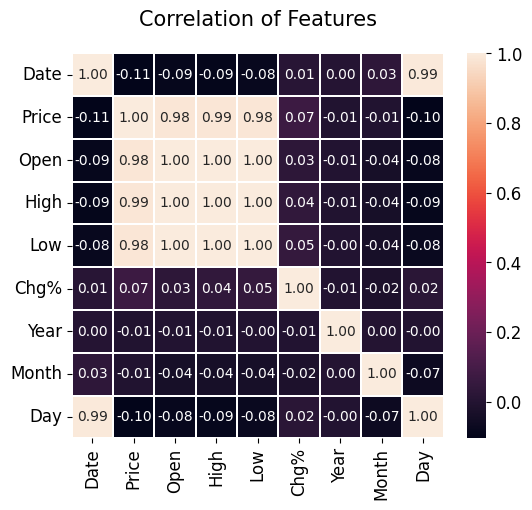

In [10]:
corr = goldprice.corr()
plt.figure(figsize = (6,5))
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            annot=True,fmt='.2f',linewidths=0.30)
plt.title('Correlation of Features', y = 1.05, size=15)

In [11]:
df = pd.DataFrame(goldprice, columns = ['Date', 'Price'])
df.head()

,Date,Price
0,2020-09-11,1957.35
1,2020-09-10,1964.30
2,2020-09-09,1954.90
3,2020-09-08,1943.20
4,2020-09-07,1937.10


In [12]:
from IPython.display import display
display(df[:10].T)

,0,1,2,3,4,5,6,7,8,9
Date,2020-09-11 00:00:00,2020-09-10 00:00:00,2020-09-09 00:00:00,2020-09-08 00:00:00,2020-09-07 00:00:00,2020-09-06 00:00:00,2020-09-04 00:00:00,2020-09-03 00:00:00,2020-09-02 00:00:00,2020-09-01 00:00:00
Price,1957.35,1964.3,1954.9,1943.2,1937.1,1940.65,1934.3,1937.8,1944.7,1978.9


In [13]:
y = df.set_index('Date')

In [14]:
y.index

DatetimeIndex(['2020-09-11', '2020-09-10', '2020-09-09', '2020-09-08',
               '2020-09-07', '2020-09-06', '2020-09-04', '2020-09-03',
               '2020-09-02', '2020-09-01',
               ...
               '2011-01-14', '2011-01-13', '2011-01-12', '2011-01-11',
               '2011-01-10', '2011-01-07', '2011-01-06', '2011-01-05',
               '2011-01-04', '2011-01-03'],
              dtype='datetime64[ns]', name='Date', length=2531, freq=None)

Exploratory Data Analysis
Explore price development

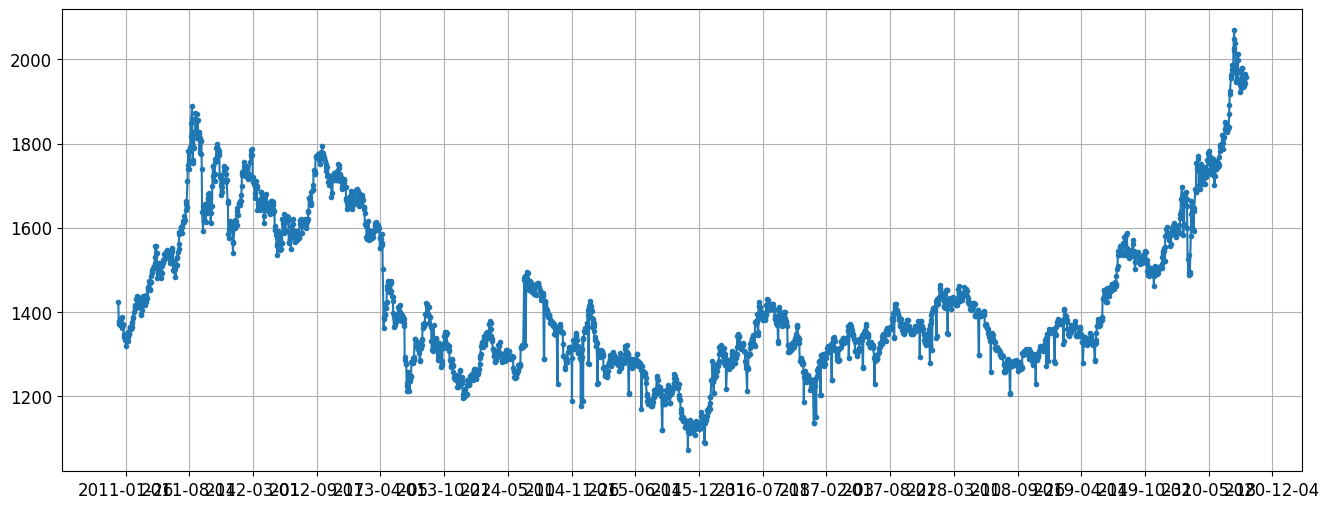

In [15]:
fig, ax = plt.subplots(figsize=(16,6))
ax.plot(df.Date, df.Price, marker='.')
ax.xaxis.set_major_locator(plt.MaxNLocator(20)) # reduce number of x-labels
plt.grid()
plt.show()

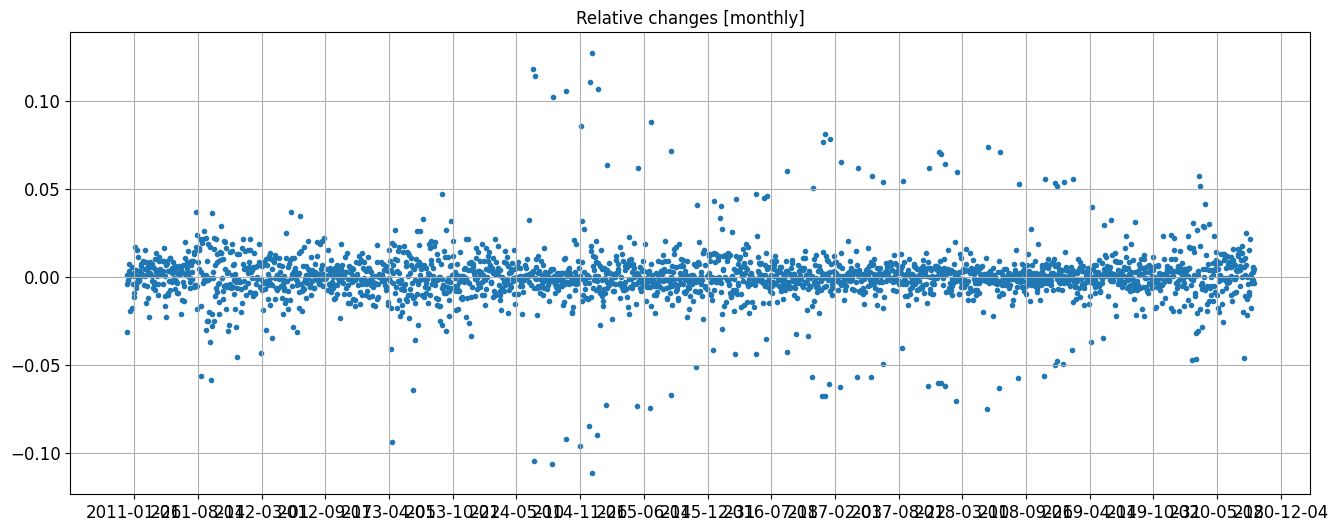

In [16]:
fig, ax = plt.subplots(figsize=(16,6))
ax.scatter(df['Date'], goldprice['Chg%'], marker='.')
ax.xaxis.set_major_locator(plt.MaxNLocator(20)) # reduce number of x-labels
plt.title('Relative changes [monthly]')
plt.grid()
plt.show()

Relative changes distribution

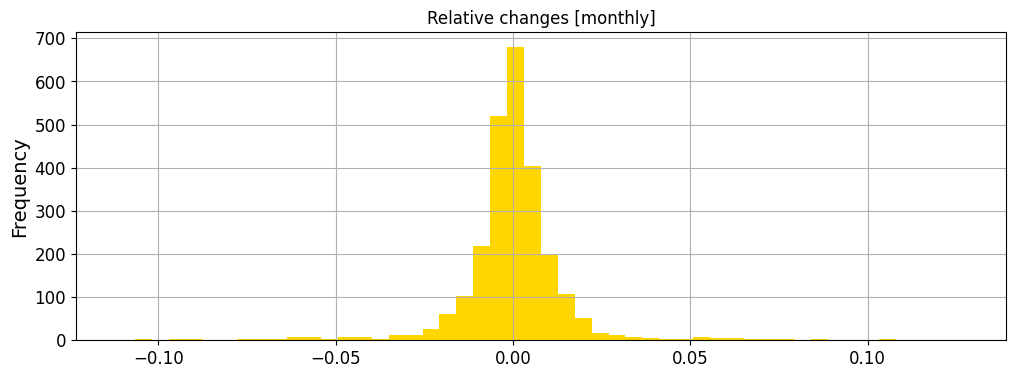

In [17]:
plt.figure(figsize=(12,4))
goldprice['Chg%'].plot(kind='hist', bins=50, color='gold')
plt.title('Relative changes [monthly]')
plt.grid()
plt.show()

In [18]:
y.isnull().sum()

,0
Price,0


In [19]:
stationary_check_gold = df.set_index(['Date'])

stationary_check_gold_price = stationary_check_gold['Price']

Non-Stationary time series of Gold

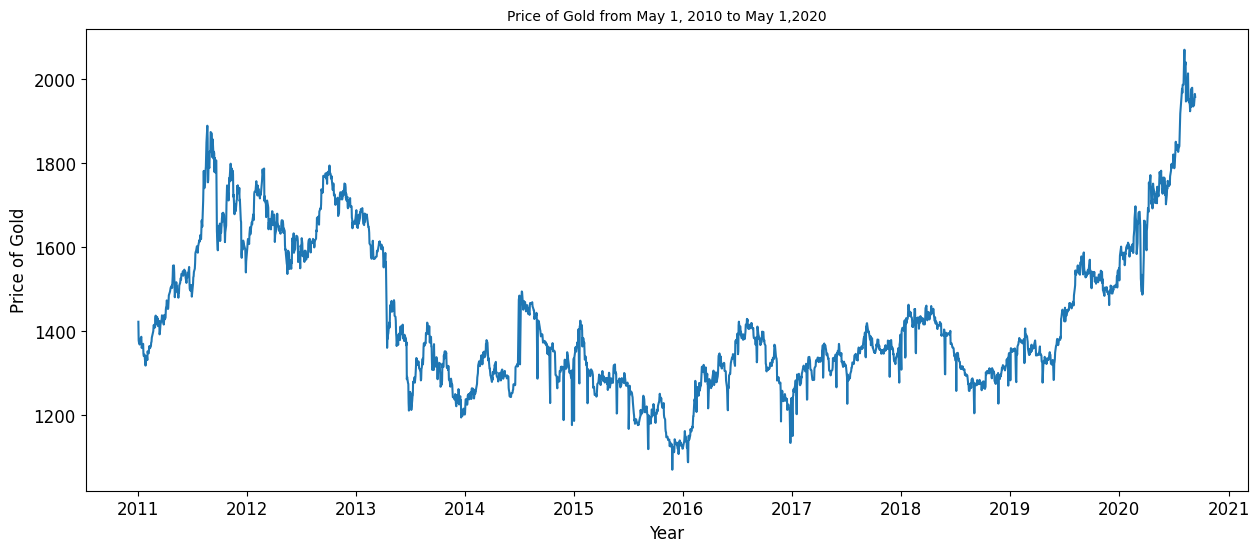

In [20]:
plt.plot(stationary_check_gold_price)
plt.ylabel('Price of Gold', fontsize=12)
plt.xlabel('Year', fontsize=12)
plt.title('Price of Gold from May 1, 2010 to May 1,2020', fontsize=10)
plt.show()

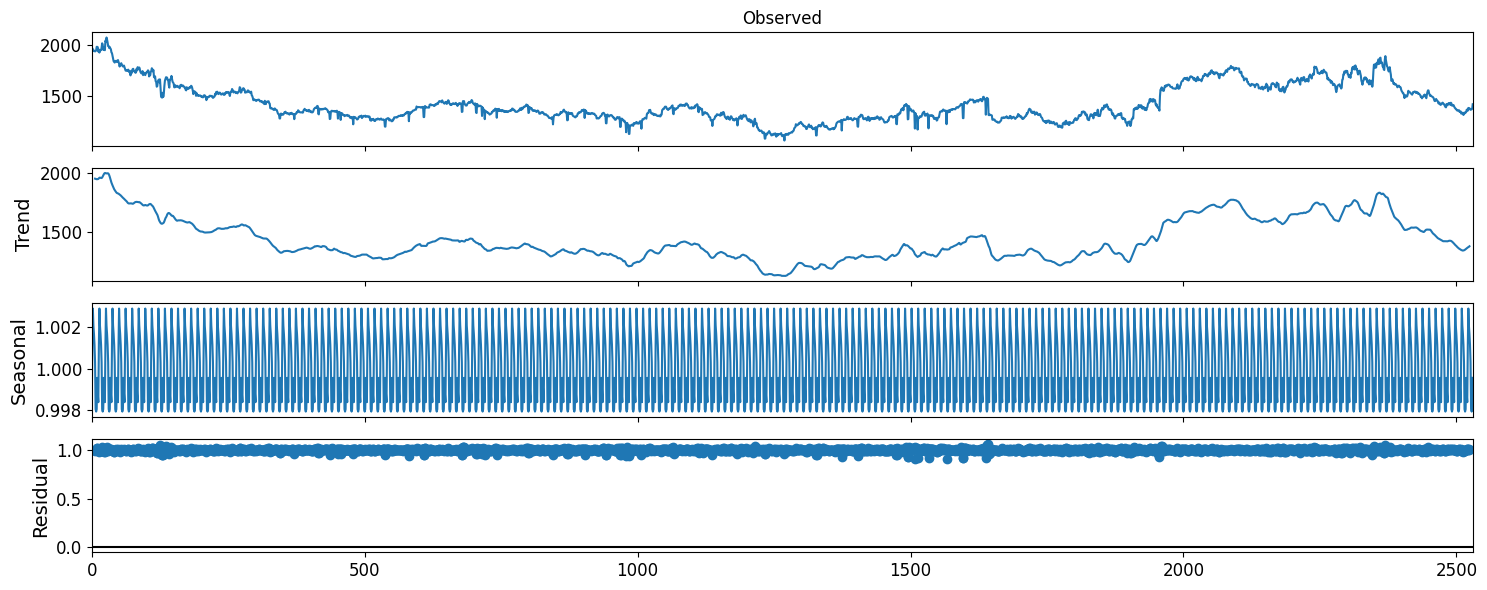

In [25]:
import statsmodels.api as sm

# multiplicative
res = sm.tsa.seasonal_decompose(stationary_check_gold_price.values, period=12, model="multiplicative")
fig = res.plot()


Box and Whisker Plots:

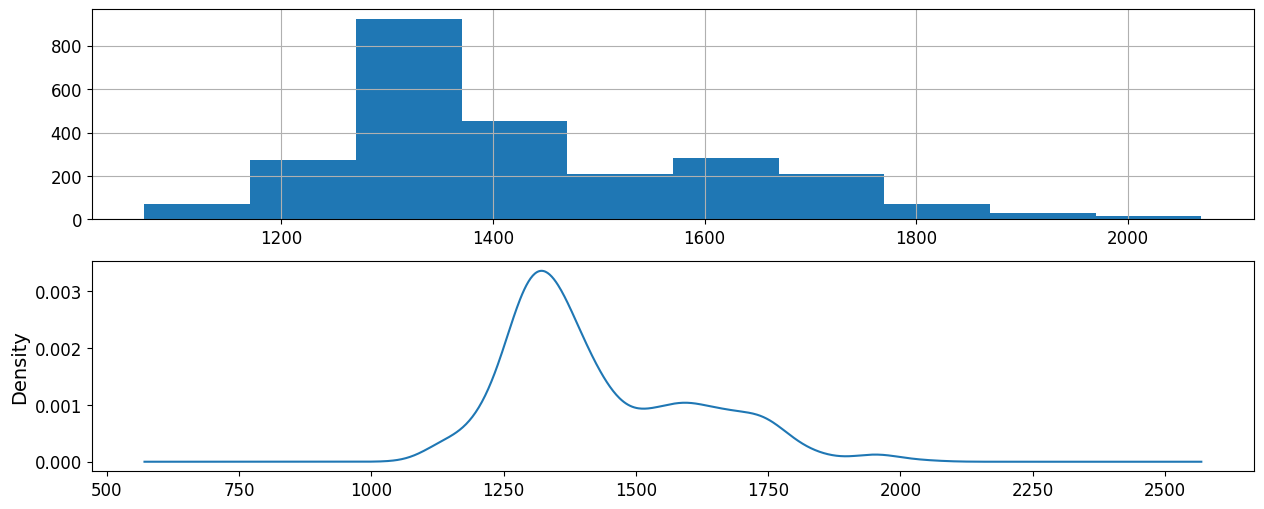

In [26]:
from pandas import Series
from matplotlib import pyplot
pyplot.figure(1)
pyplot.subplot(211)
stationary_check_gold_price.hist()
pyplot.subplot(212)
stationary_check_gold_price.plot(kind='kde')
pyplot.show()

<Axes: xlabel='Date'>

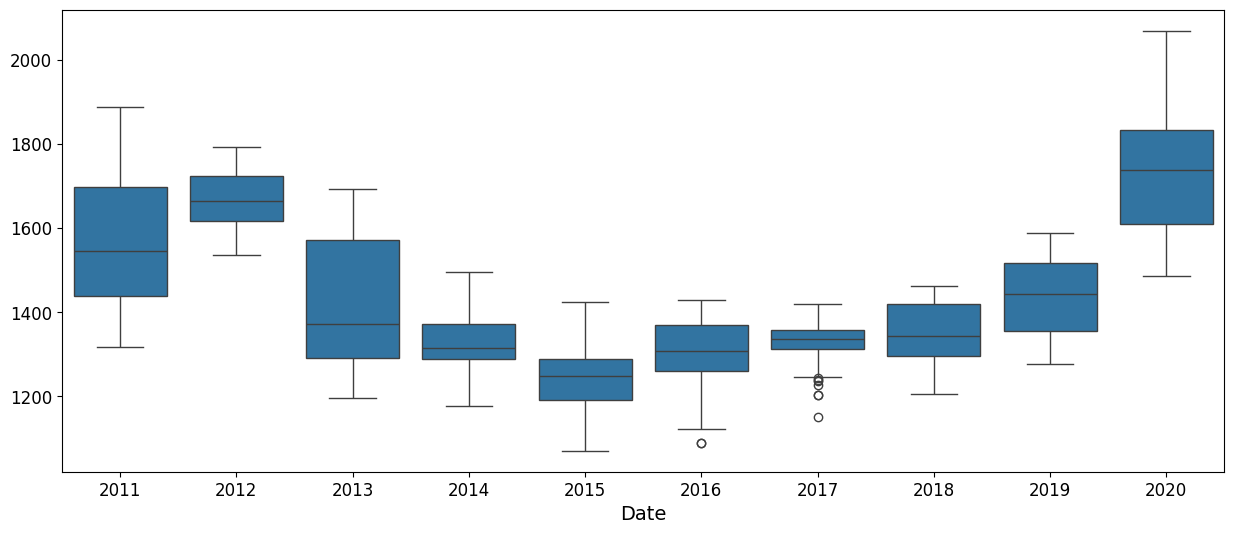

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 6))
sns.boxplot(x=stationary_check_gold_price.index.year, y=stationary_check_gold_price.values, ax=ax)


Plotting the Stationarity

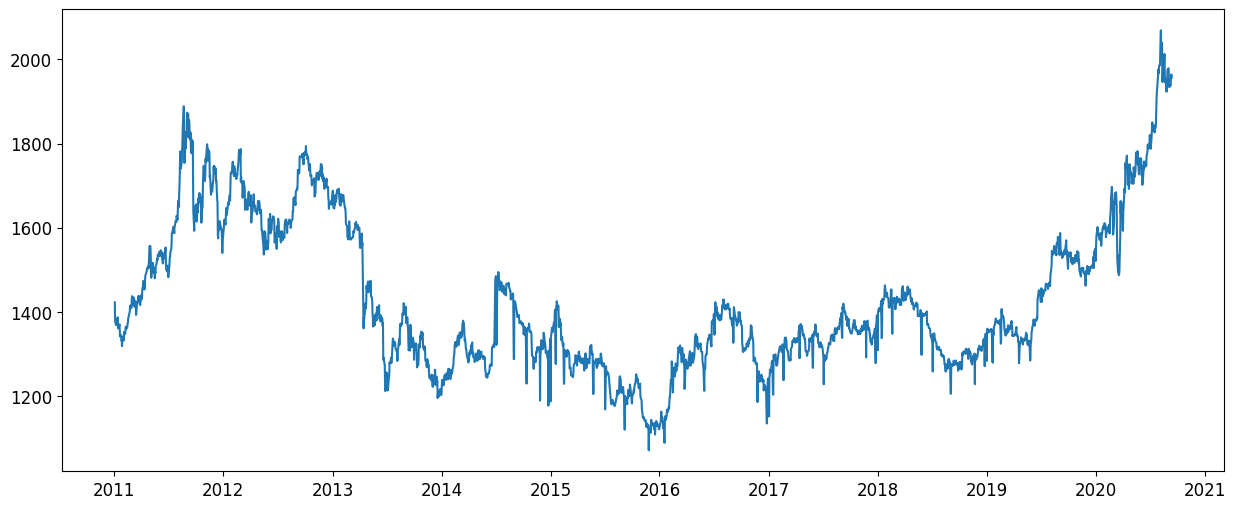

In [29]:
plt.plot(stationary_check_gold_price)

Analysing the Stationarity using Autocorrelation and Partial Autocorrelation functions

Autocorrelations

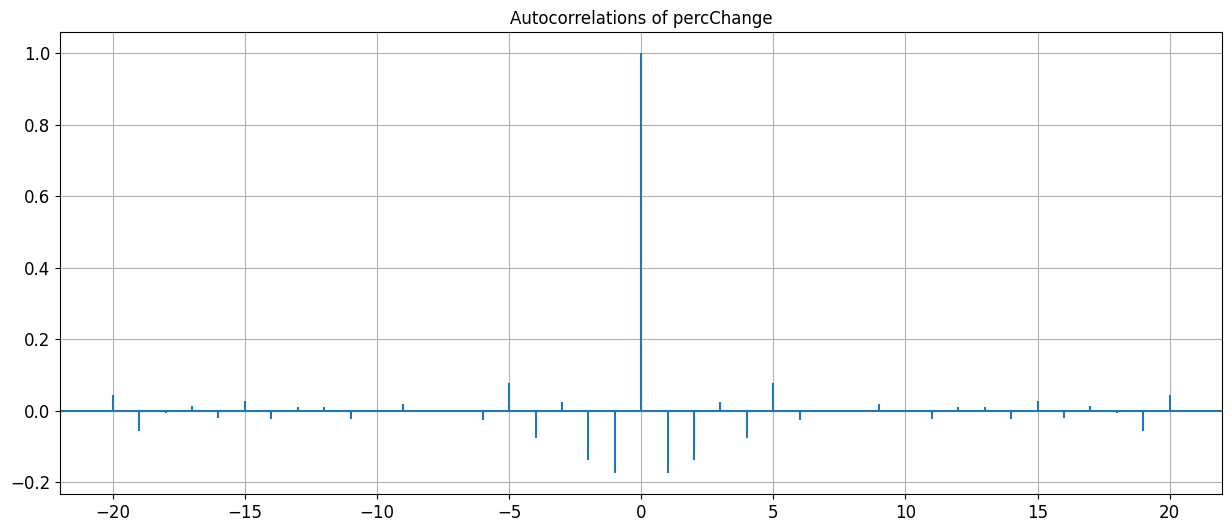

In [30]:
plt.acorr(goldprice['Chg%'], maxlags=20)
plt.title('Autocorrelations of percChange')
plt.grid()
plt.show()

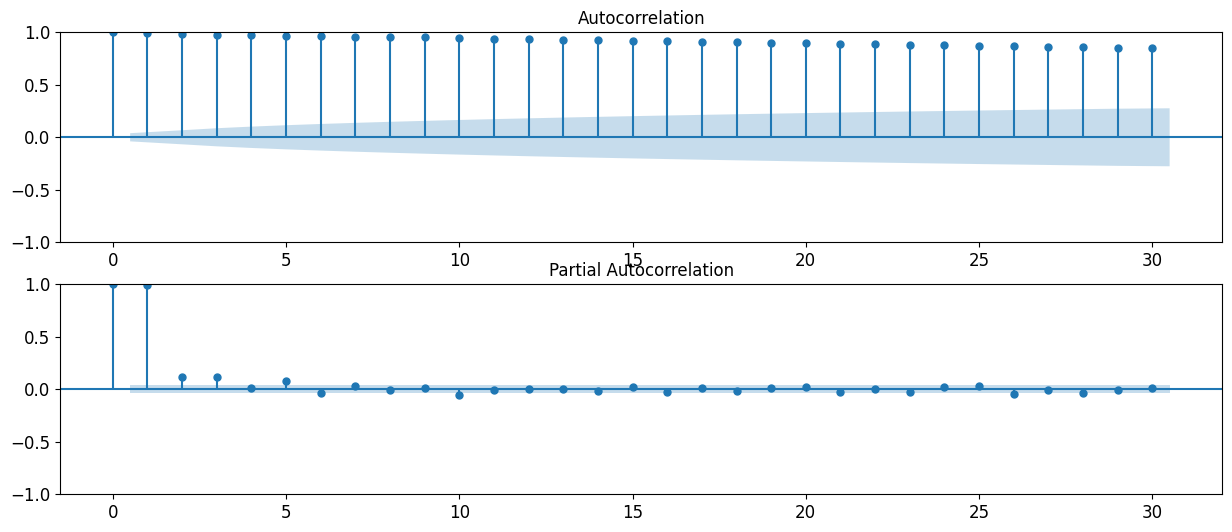

In [31]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

pyplot.figure()
pyplot.subplot(211)
plot_acf(stationary_check_gold_price, ax=pyplot.gca(), lags = 30)
pyplot.subplot(212)
plot_pacf(stationary_check_gold_price, ax=pyplot.gca(), lags = 30)
pyplot.show()

Plotting Rolling Statistics

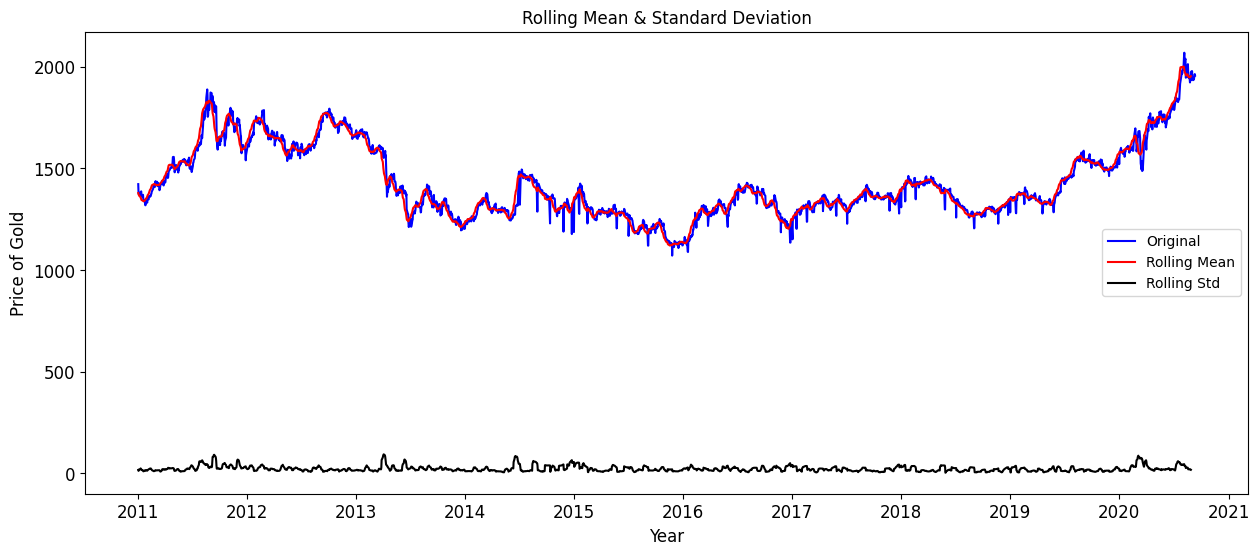

Results of Dickey-Fuller Test:
Test Statistic                   -3.030208
p-value                           0.032168
#Lags Used                        6.000000
Number of Observations Used    2524.000000
Critical Value (1%)              -3.432943
Critical Value (5%)              -2.862686
Critical Value (10%)             -2.567380
dtype: float64


In [32]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):

    #Determing rolling statistics
    #rolmean = pd.rolling_mean(timeseries, window=12)
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    #rolstd = pd.rolling_std(timeseries, window=12)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.ylabel('Price of Gold', fontsize=12)
    plt.xlabel('Year', fontsize=12)
    plt.show(block=False)

    #Perform Dickey-Fuller test:
    print( 'Results of Dickey-Fuller Test:' )
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

test_stationarity(stationary_check_gold_price)

Perfroming Augmented Dickey-Fuller Test

In [33]:
from statsmodels.tsa.stattools import adfuller
print ('Results of Dickey-Fuller Test:')
dftest = adfuller(stationary_check_gold_price, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                   -3.030208
p-value                           0.032168
#Lags Used                        6.000000
Number of Observations Used    2524.000000
Critical Value (1%)              -3.432943
Critical Value (5%)              -2.862686
Critical Value (10%)             -2.567380
dtype: float64


In [34]:
def test_stationarity(timeseries):

    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

Making Time Series Stationary using Log Scale Transformation

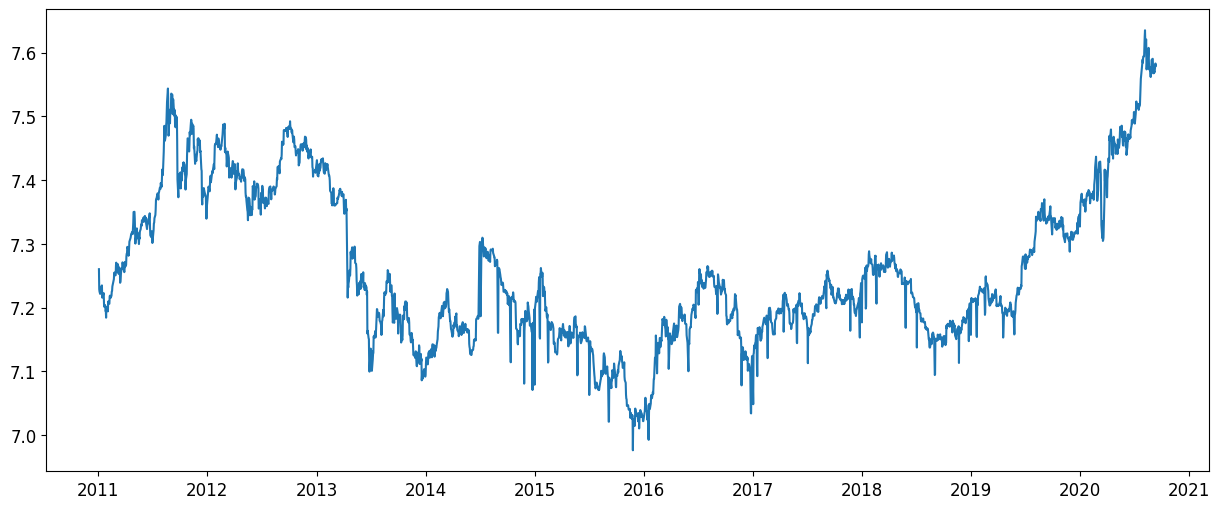

In [35]:
ts_log = np.log(stationary_check_gold_price)
plt.plot(ts_log)

Using multiple techniques to remove Trend - Smoothing

Moving Average

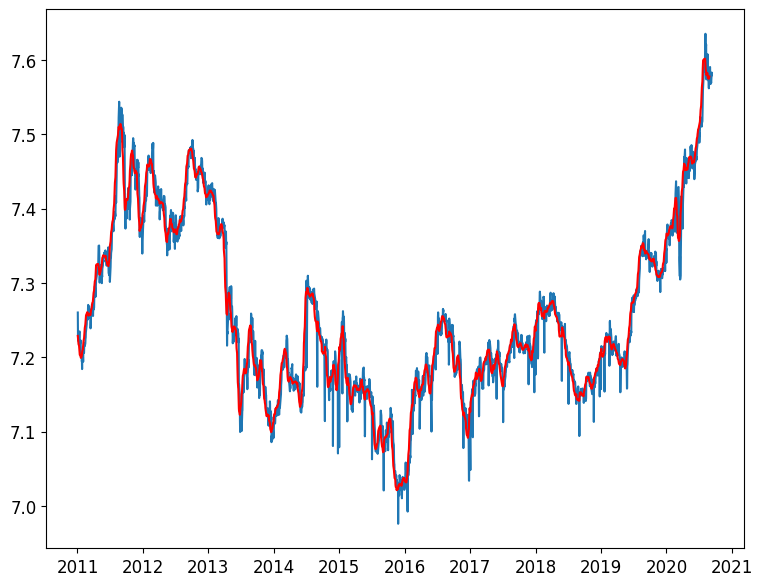

In [36]:
moving_avg = ts_log.rolling(window=12,center=False).mean()  # taking average of LAST 2 years (36-12) values
plt.figure(figsize=(9,7))
plt.plot(ts_log)
plt.plot(moving_avg, color='red')
plt.show()

In [37]:
ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.head(12)

,Price
Date,
2020-09-11,NaN
2020-09-10,NaN
2020-09-09,NaN
2020-09-08,NaN
2020-09-07,NaN
2020-09-06,NaN
2020-09-04,NaN
2020-09-03,NaN
2020-09-02,NaN


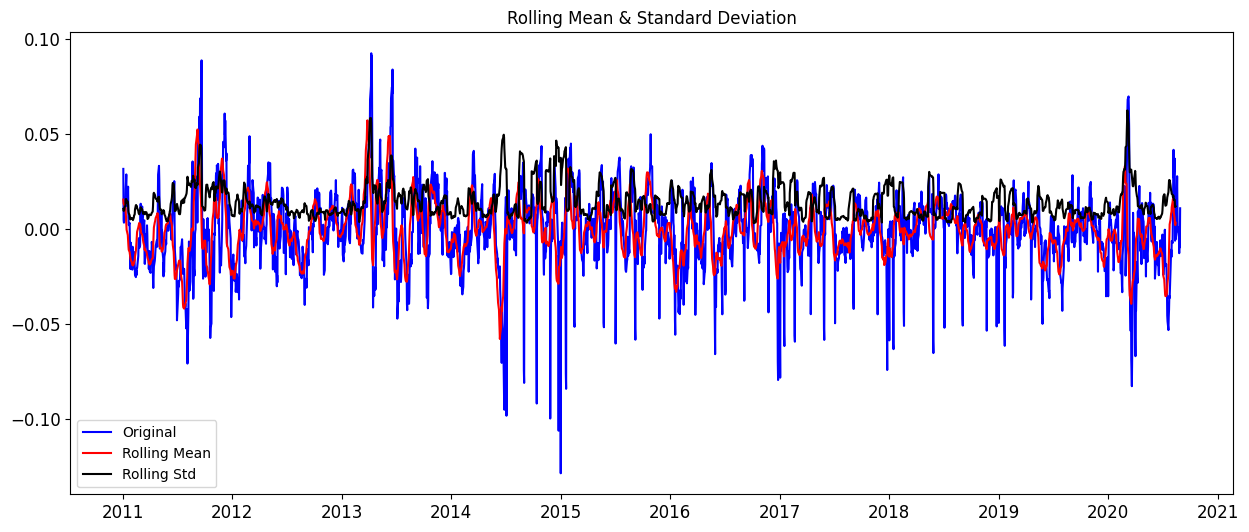

Results of Dickey-Fuller Test:
Test Statistic                -1.194664e+01
p-value                        4.414553e-22
#Lags Used                     1.100000e+01
Number of Observations Used    2.508000e+03
Critical Value (1%)           -3.432960e+00
Critical Value (5%)           -2.862693e+00
Critical Value (10%)          -2.567384e+00
dtype: float64


In [38]:
ts_log_moving_avg_diff.dropna(inplace=True)
test_stationarity(ts_log_moving_avg_diff)

Splitting the data

In [39]:
X = goldprice.drop(['Date','Price'],axis=1)
X

,Open,High,Low,Chg%,Year,Month,Day
0,1952.55,1963.3,1944.35,-0.0035,11,9,2020
1,1955.30,1975.2,1948.60,0.0048,10,9,2020
2,1939.40,1959.7,1926.30,0.0060,9,9,2020
3,1938.00,1948.3,1911.70,0.0031,8,9,2020
4,1940.70,1947.4,1930.45,-0.0018,7,9,2020
...,...,...,...,...,...,...,...
2526,1372.70,1377.2,1355.50,-0.0021,7,1,2011
2527,1374.80,1376.5,1368.90,-0.0015,6,1,2011
2528,1383.40,1384.0,1364.20,-0.0037,5,1,2011
2529,1409.60,1410.9,1375.80,-0.0310,4,1,2011


In [40]:
X.shape

(2531, 7)

In [41]:
y = goldprice['Price']
y

,Price
0,1957.35
1,1964.30
2,1954.90
3,1943.20
4,1937.10
...,...
2526,1368.50
2527,1371.40
2528,1373.40
2529,1378.50


In [42]:
y.shape

(2531,)

In [43]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=2)

Using Random Forest Regressor

In [44]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

In [45]:
def predict(algorithm):
    model = algorithm.fit(X_train,y_train)
    print('Training Score: {}'.format(model.score(X_train,y_train)))

    preds = model.predict(X_test)
    print('Predictions are: {}'.format(preds))
    print('\n')

    r2_score = metrics.r2_score(y_test,preds)
    print('r2_score is:{}'.format(r2_score))

    print('MAE:',metrics.mean_absolute_error(y_test,preds))
    print('MSE:',metrics.mean_squared_error(y_test,preds))
    print('RMSE:',np.sqrt(metrics.mean_squared_error(y_test,preds)))
    sns.distplot(y_test-preds,color='green')

Training Score: 0.9995326156264086
Predictions are: [1280.284  1373.936  1346.3088 1717.1    1333.9285 1290.06   1143.17
 1345.377  1265.7441 1304.66   1713.792  1344.5534 1360.933  1282.2395
 1571.057  1313.761  1332.64   1405.826  1524.6125 1335.533  1755.356
 1337.6092 1416.282  1265.653  1328.467  1539.271  1748.603  1202.341
 1593.175  1960.119  1360.125  1335.685  1678.566  1398.87   1322.862
 1361.148  1586.6135 1394.888  1650.088  1368.564  1195.2665 1362.657
 1427.808  1243.055  1312.154  1284.9925 1627.75   1367.933  1444.424
 1335.351  1279.1755 1595.448  1355.406  1543.276  1445.99   1304.636
 1272.199  1535.572  1265.2307 1520.025  1372.826  1755.281  1754.488
 1583.347  1347.636  1640.882  1247.071  1676.051  1551.4415 1496.874
 1629.197  1454.383  1580.9505 1678.369  1568.7385 1560.9535 1231.627
 1233.0525 1323.9325 1257.384  1358.045  1493.05   1350.447  1340.049
 1568.87   1596.266  1296.37   1446.255  1601.803  1573.794  1279.106
 1322.667  1411.915  1433.752  1609.27

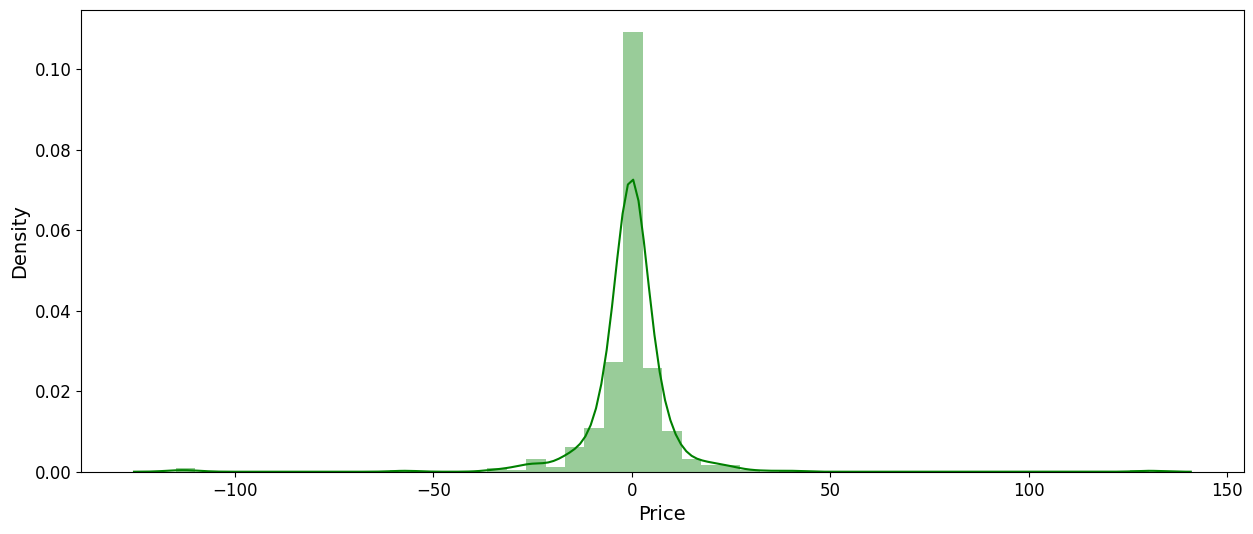

In [46]:
from sklearn.ensemble import RandomForestRegressor

predict(RandomForestRegressor())

Using Linear Regression

Training Score: 0.9720489762983339
Predictions are: [1287.46509401 1381.1335197  1349.02699003 1708.15351128 1337.6139623
 1305.2974777  1176.84026124 1348.79406241 1274.67616002 1316.54671617
 1722.3847627  1348.61530229 1370.70980134 1292.16250098 1569.34503439
 1316.63295296 1335.3827299  1411.79896563 1527.80814535 1330.94094103
 1739.072931   1341.43834851 1422.95738006 1270.20100171 1332.58185012
 1548.35263609 1740.92377919 1218.09105188 1585.98911985 1952.22431769
 1376.77944912 1345.10439649 1675.54758129 1278.10874728 1324.17910345
 1363.29713204 1602.85035255 1396.97035239 1646.77730068 1375.16890577
 1217.21910521 1392.55717245 1419.43210369 1265.89287443 1335.27249572
 1288.03513898 1624.16678634 1369.81739241 1439.40405146 1337.01326427
 1301.14760161 1597.38675689 1369.60254536 1544.02617924 1442.70147853
 1309.45200532 1285.29685425 1540.80458533 1272.27537545 1541.33150534
 1390.21604477 1749.5876601  1750.43403024 1610.78462962 1356.7009396
 1658.18878433 1275.8347959

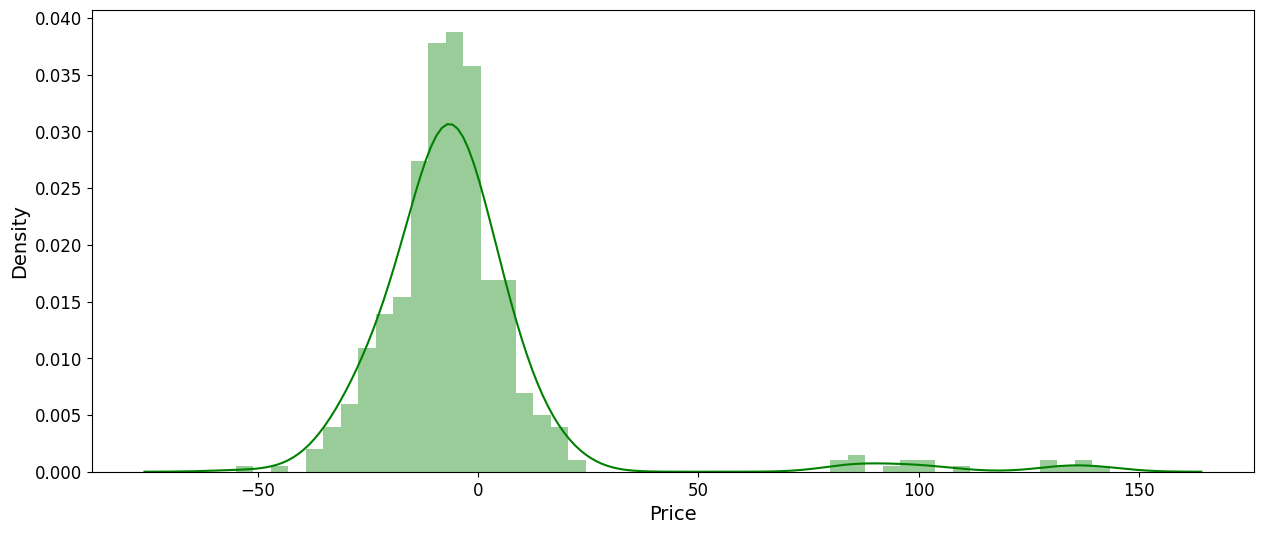

In [47]:
from sklearn.linear_model import LinearRegression

predict(LinearRegression())

Using KNNs

Training Score: 0.9837444890953134
Predictions are: [1279.48 1374.9  1404.26 1724.9  1328.86 1323.04 1168.06 1345.26 1265.88
 1305.78 1714.38 1342.8  1361.6  1282.3  1570.3  1313.98 1333.76 1409.06
 1525.58 1391.14 1746.76 1335.34 1418.38 1263.28 1328.9  1535.54 1756.98
 1246.56 1592.02 1968.   1356.22 1330.64 1684.4  1319.74 1322.74 1362.52
 1587.44 1394.04 1650.4  1370.28 1221.7  1368.46 1424.7  1243.72 1346.72
 1287.26 1628.64 1367.04 1441.18 1334.74 1277.46 1600.12 1355.3  1540.3
 1445.76 1303.64 1272.5  1536.56 1265.18 1528.82 1372.6  1753.12 1757.42
 1595.9  1347.3  1630.96 1249.8  1670.56 1552.92 1494.9  1613.12 1454.44
 1590.62 1674.54 1566.66 1561.   1255.75 1259.1  1320.39 1255.08 1358.76
 1490.02 1347.24 1296.   1563.72 1591.84 1326.8  1443.58 1599.68 1575.54
 1330.8  1325.96 1413.24 1431.56 1607.38 1537.47 1788.48 1291.58 1308.74
 1272.38 1779.96 1252.67 1417.5  1222.62 1366.28 1289.78 1459.58 1495.3
 1576.26 1413.76 1736.14 1428.78 1387.48 1946.28 1678.92 1651.72 1305.
 12

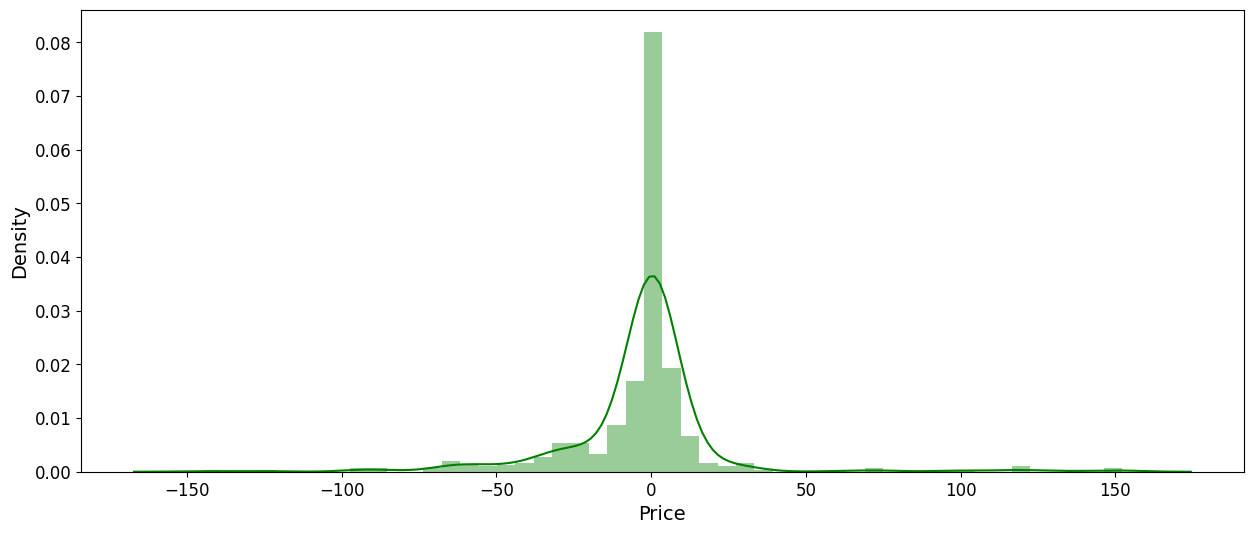

In [48]:
from sklearn.neighbors import KNeighborsRegressor

predict(KNeighborsRegressor())

Using Decision Tree

Training Score: 1.0
Predictions are: [1280.2  1374.5  1340.2  1714.1  1328.2  1293.8  1141.3  1345.6  1265.8
 1303.5  1708.8  1343.5  1363.8  1282.   1563.1  1313.7  1336.8  1408.
 1523.   1332.   1755.2  1336.2  1419.   1267.6  1328.5  1535.1  1750.4
 1203.5  1592.4  1946.5  1348.3  1328.2  1684.1  1439.   1322.5  1364.
 1564.5  1394.8  1652.2  1368.   1195.2  1373.6  1433.1  1242.4  1312.4
 1285.5  1625.7  1366.8  1434.1  1335.8  1276.4  1599.   1359.8  1545.4
 1447.8  1297.6  1272.4  1537.2  1264.4  1515.   1371.2  1762.   1768.6
 1592.5  1346.3  1638.9  1250.6  1683.3  1551.8  1499.1  1641.9  1456.
 1524.9  1683.3  1581.4  1561.9  1225.3  1221.7  1325.9  1257.3  1358.1
 1491.   1359.8  1366.6  1563.1  1586.2  1297.6  1446.3  1615.2  1562.9
 1268.   1324.2  1410.7  1429.4  1587.   1539.6  1794.1  1358.5  1280.1
 1271.7  1787.   1262.4  1416.2  1197.7  1368.   1287.6  1452.3  1493.2
 1574.8  1414.2  1730.6  1428.1  1385.5  1934.3  1671.4  1659.1  1306.4
 1291.9  1740.   1433.1  1323.

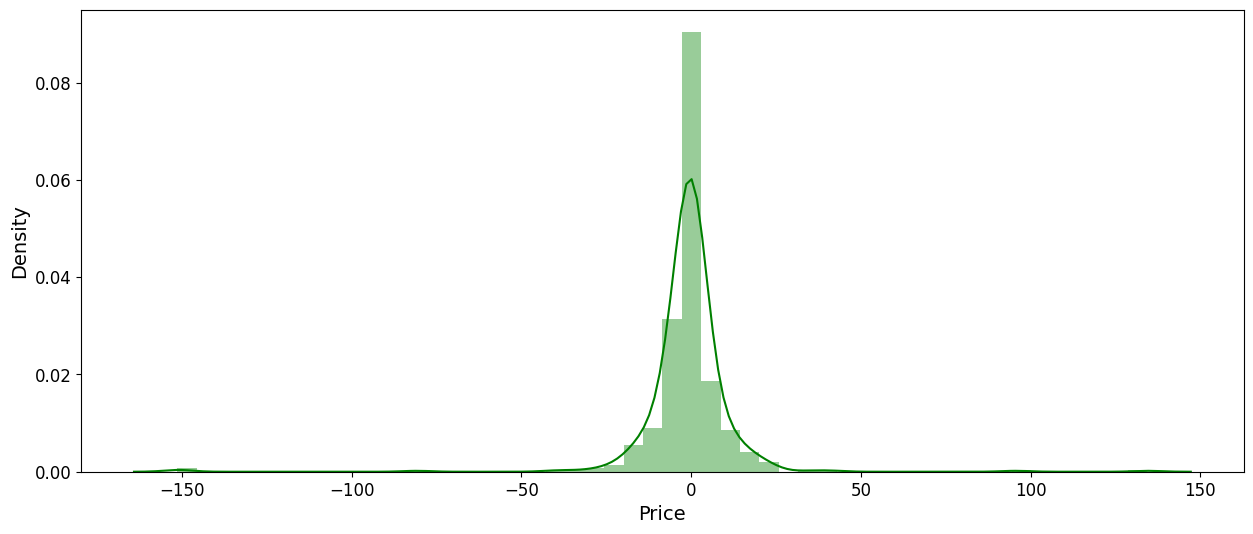

In [49]:
from sklearn.tree import DecisionTreeRegressor

predict(DecisionTreeRegressor())

Using XGBoost

Training Score: 0.9999229443115288
Predictions are: [1278.1401 1371.271  1355.9695 1723.461  1334.4335 1297.1885 1143.4845
 1345.4817 1261.3967 1301.5546 1712.7925 1346.2677 1361.0388 1280.0442
 1570.3239 1307.7097 1330.5502 1405.5698 1528.4703 1334.4691 1751.9741
 1339.1648 1416.658  1269.2885 1328.5906 1542.5172 1746.5859 1201.6
 1589.8477 1968.6177 1368.1272 1332.0349 1681.0333 1411.5604 1321.3562
 1368.2838 1587.745  1392.7683 1653.4155 1365.9961 1190.6746 1366.0255
 1425.8407 1248.3562 1309.78   1283.9656 1634.9989 1366.5922 1443.5984
 1332.3934 1309.3379 1592.4606 1358.125  1543.663  1444.7942 1301.2952
 1272.8468 1533.4299 1265.3164 1530.9901 1368.8342 1759.8955 1754.0508
 1556.21   1344.388  1647.2428 1247.8563 1674.9934 1552.3225 1503.549
 1619.5886 1457.717  1614.9015 1673.7311 1571.3754 1561.7765 1238.839
 1240.098  1323.3727 1261.1567 1357.4338 1501.3079 1351.5875 1360.682
 1565.3318 1599.4858 1296.2756 1444.8475 1604.5632 1580.2817 1298.9015
 1335.5979 1414.1458 1437.333  

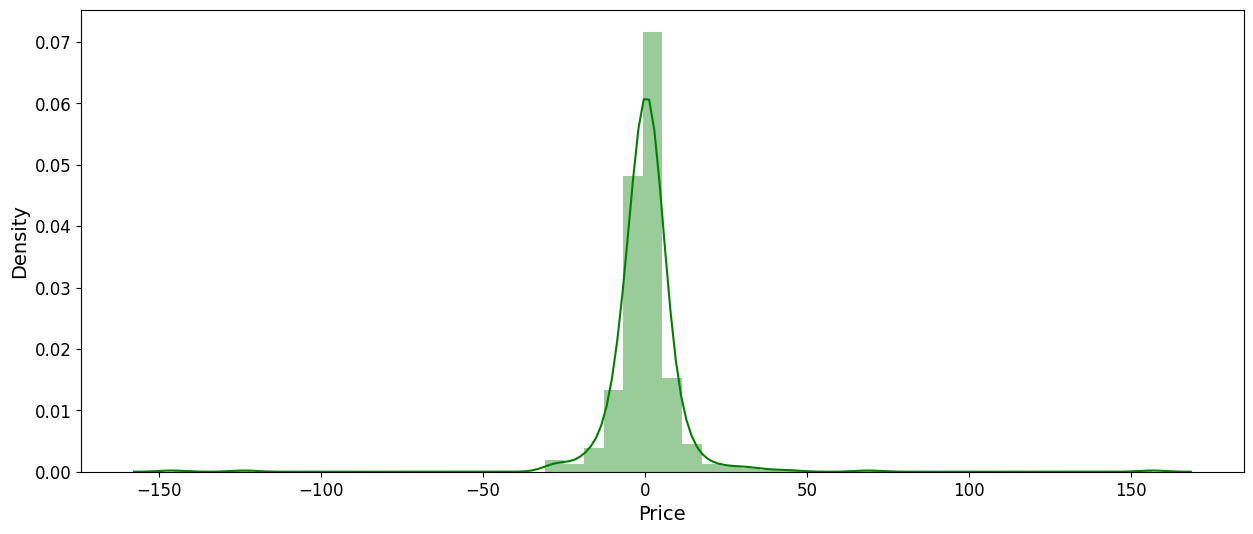

In [51]:
from xgboost import XGBRegressor

predict(XGBRegressor())

Building the ARIMA model

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsm

                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                 2531
Model:                 ARIMA(5, 1, 0)   Log Likelihood              -11341.408
Date:                Sun, 01 Sep 2024   AIC                          22694.815
Time:                        07:09:32   BIC                          22729.831
Sample:                             0   HQIC                         22707.520
                               - 2531                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1807      0.010    -17.657      0.000      -0.201      -0.161
ar.L2         -0.1713      0.012    -13.747      0.000      -0.196      -0.147
ar.L3         -0.0402      0.022     -1.789      0.0

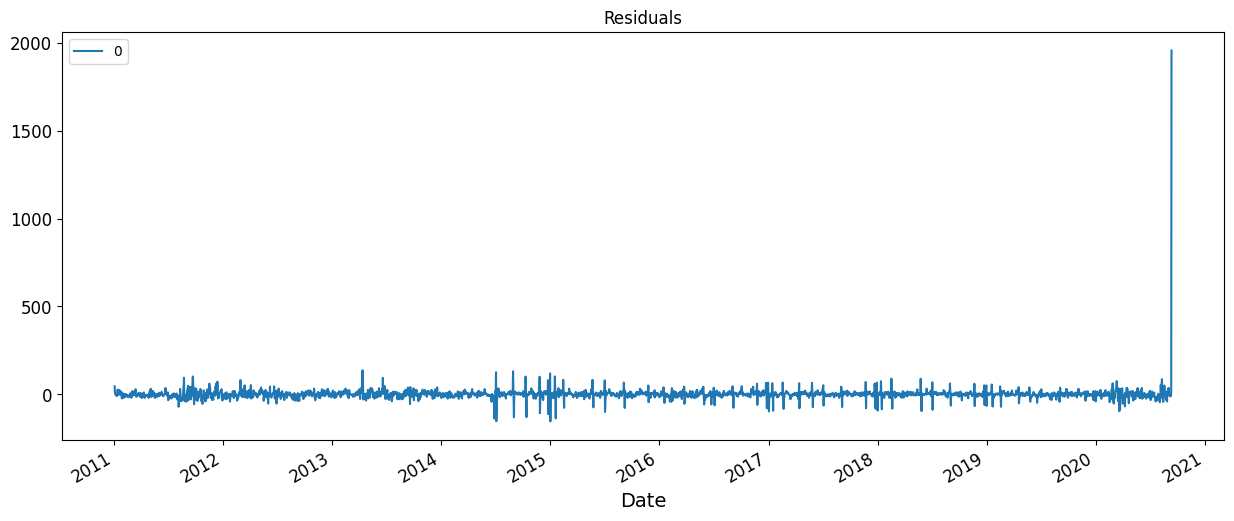

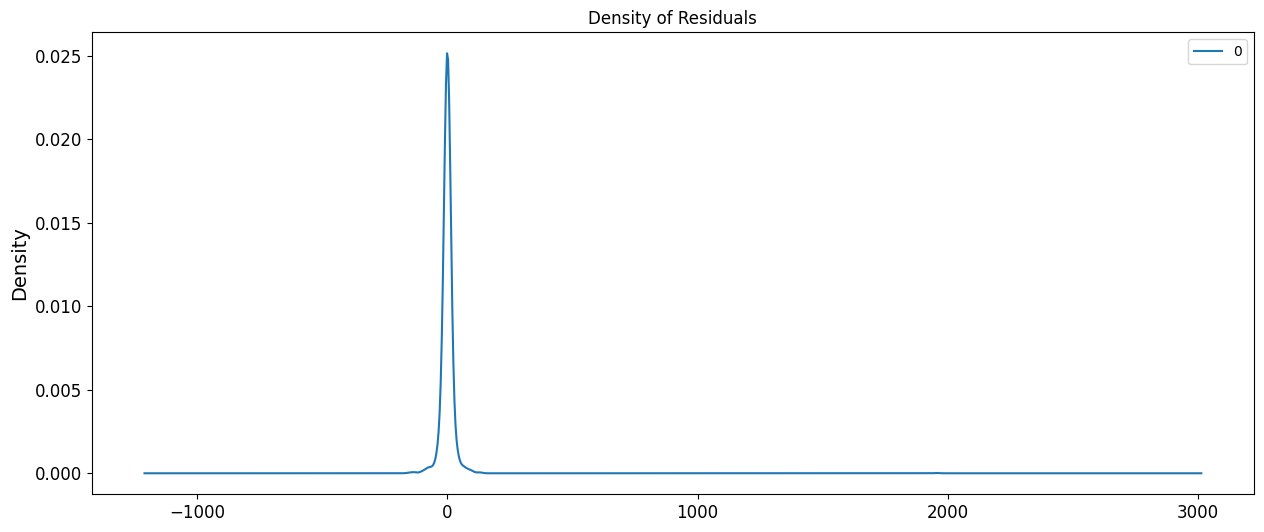

                 0
count  2531.000000
mean      0.455939
std      44.412299
min    -154.536356
25%      -8.246394
50%      -0.037432
75%       7.817965
max    1957.350000


In [53]:
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from pandas import DataFrame

# fit model
model = ARIMA(stationary_check_gold_price, order=(5, 1, 0))
model_fit = model.fit()

# print model summary
print(model_fit.summary())

# plot residual errors
residuals = DataFrame(model_fit.resid)
residuals.plot(title="Residuals")
plt.show()

residuals.plot(kind='kde', title="Density of Residuals")
plt.show()

print(residuals.describe())


In [54]:
stationary_check_gold_price.values

array([1957.35, 1964.3 , 1954.9 , ..., 1373.4 , 1378.5 , 1422.6 ])

predicted=1212.490496, expected=1201.900000
predicted=1208.876591, expected=1203.100000
predicted=1207.223054, expected=1216.100000
predicted=1215.352889, expected=1214.100000
predicted=1211.395029, expected=1205.100000
predicted=1206.496677, expected=1198.400000
predicted=1200.701240, expected=1205.100000
predicted=1206.384925, expected=1195.000000
predicted=1197.636004, expected=1236.100000
predicted=1228.556401, expected=1231.200000
predicted=1221.990986, expected=1245.500000
predicted=1241.119519, expected=1235.700000
predicted=1229.127670, expected=1226.000000
predicted=1230.999538, expected=1258.500000
predicted=1251.559874, expected=1262.400000
predicted=1255.801621, expected=1235.300000
predicted=1239.465422, expected=1230.300000
predicted=1233.284087, expected=1233.200000
predicted=1236.111901, expected=1248.200000
predicted=1248.001865, expected=1221.700000
predicted=1224.512974, expected=1222.300000
predicted=1226.976684, expected=1250.600000
predicted=1243.646926, expected=

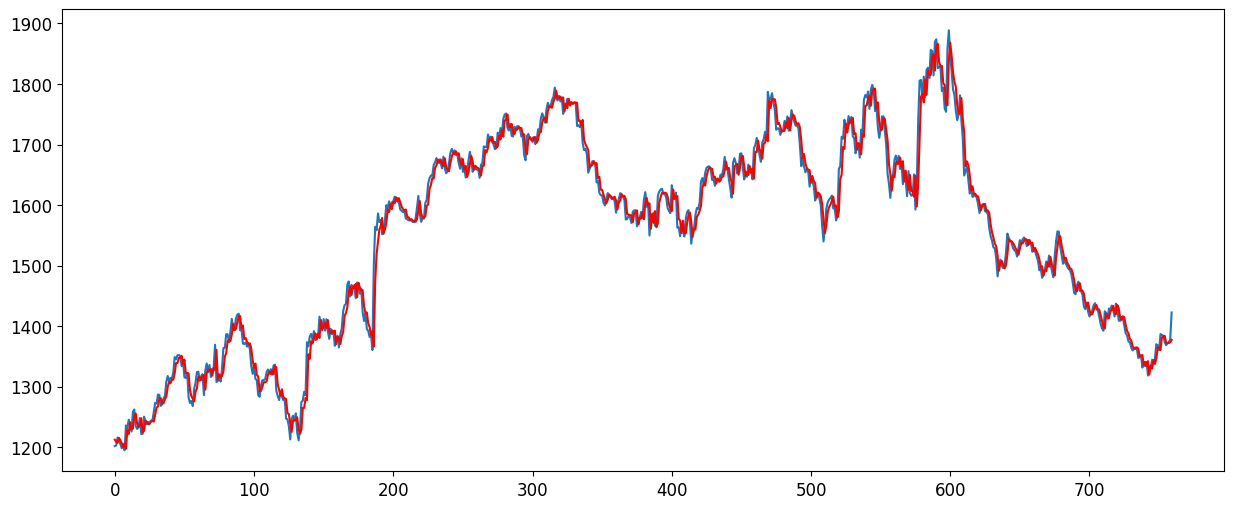

In [57]:
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

X = stationary_check_gold_price.values
size = int(len(X) * 0.7)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()

for t in range(len(test)):
    model = ARIMA(history, order=(5, 1, 0))
    model_fit = model.fit()
    output = model_fit.forecast()
    y_pred = output[0]
    predictions.append(y_pred)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (y_pred, obs))

error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

# plot the forecast
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()


Using this ARIMA model on differenciated outputs

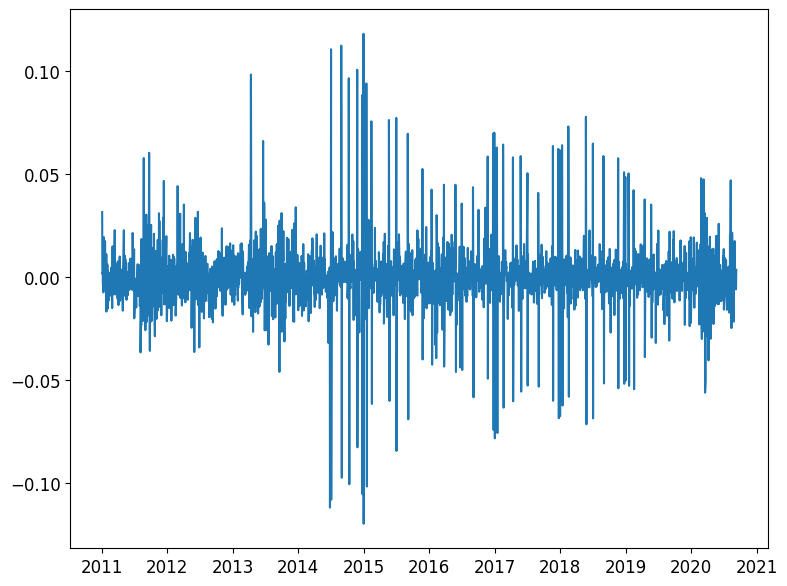

In [58]:
ts_log_diff = ts_log - ts_log.shift()
plt.figure(figsize=(9,7))
plt.plot(ts_log_diff)
plt.show()

In [59]:
ts_log_diff.head()

,Price
Date,
2020-09-11,NaN
2020-09-10,0.003544
2020-09-09,-0.004797
2020-09-08,-0.006003
2020-09-07,-0.003144


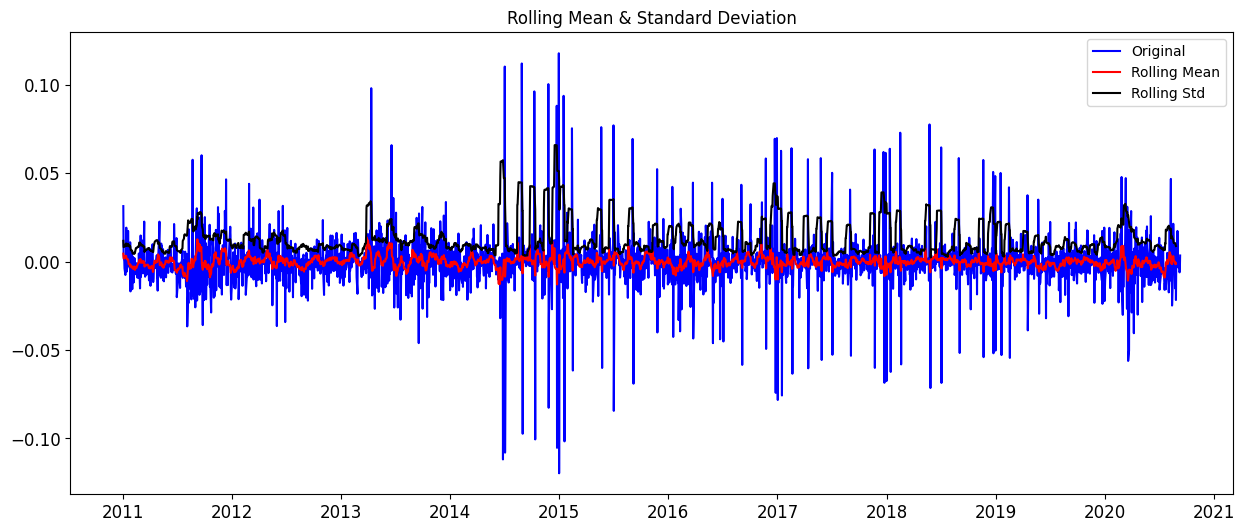

Results of Dickey-Fuller Test:
Test Statistic                  -24.003958
p-value                           0.000000
#Lags Used                        5.000000
Number of Observations Used    2524.000000
Critical Value (1%)              -3.432943
Critical Value (5%)              -2.862686
Critical Value (10%)             -2.567380
dtype: float64


In [60]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

In [61]:
ts_log_diff.head()

,Price
Date,
2020-09-10,0.003544
2020-09-09,-0.004797
2020-09-08,-0.006003
2020-09-07,-0.003144
2020-09-06,0.001831


In [62]:
from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')

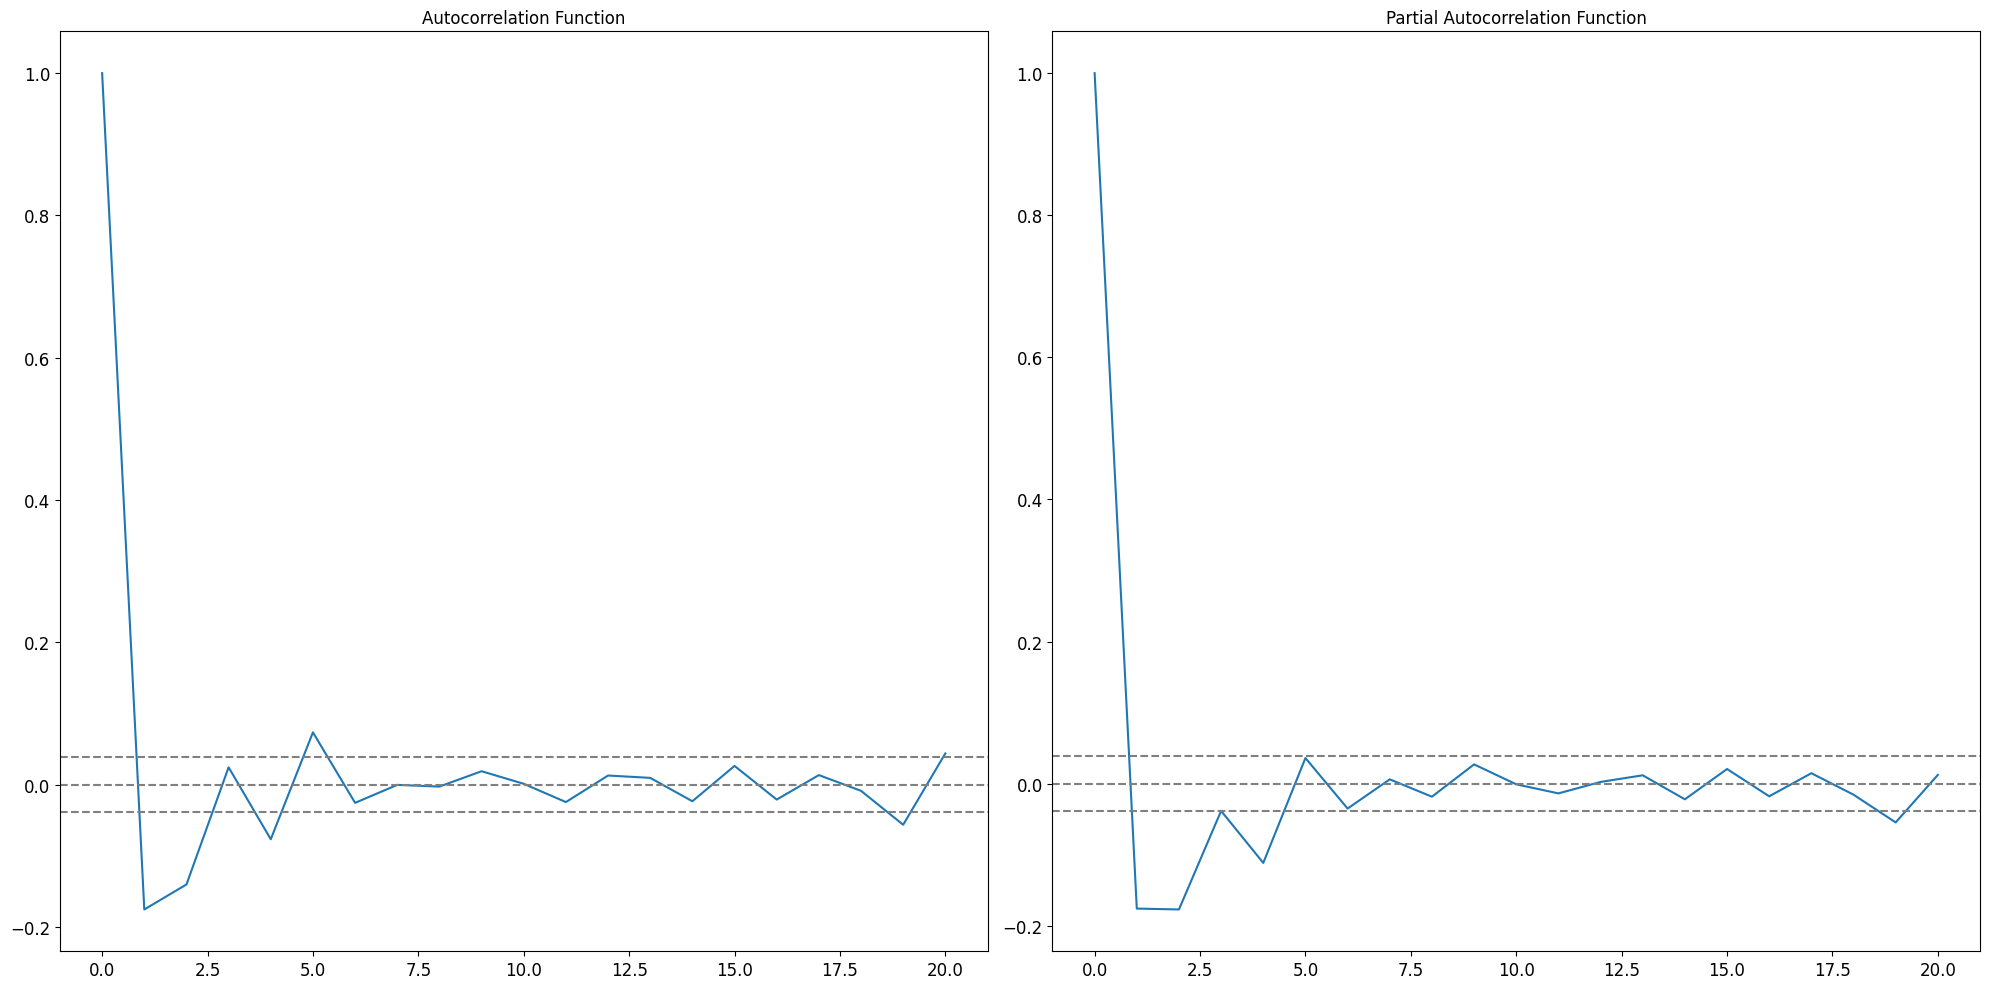

In [63]:
plt.figure(figsize=(20,10))

#Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()
plt.show()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsm

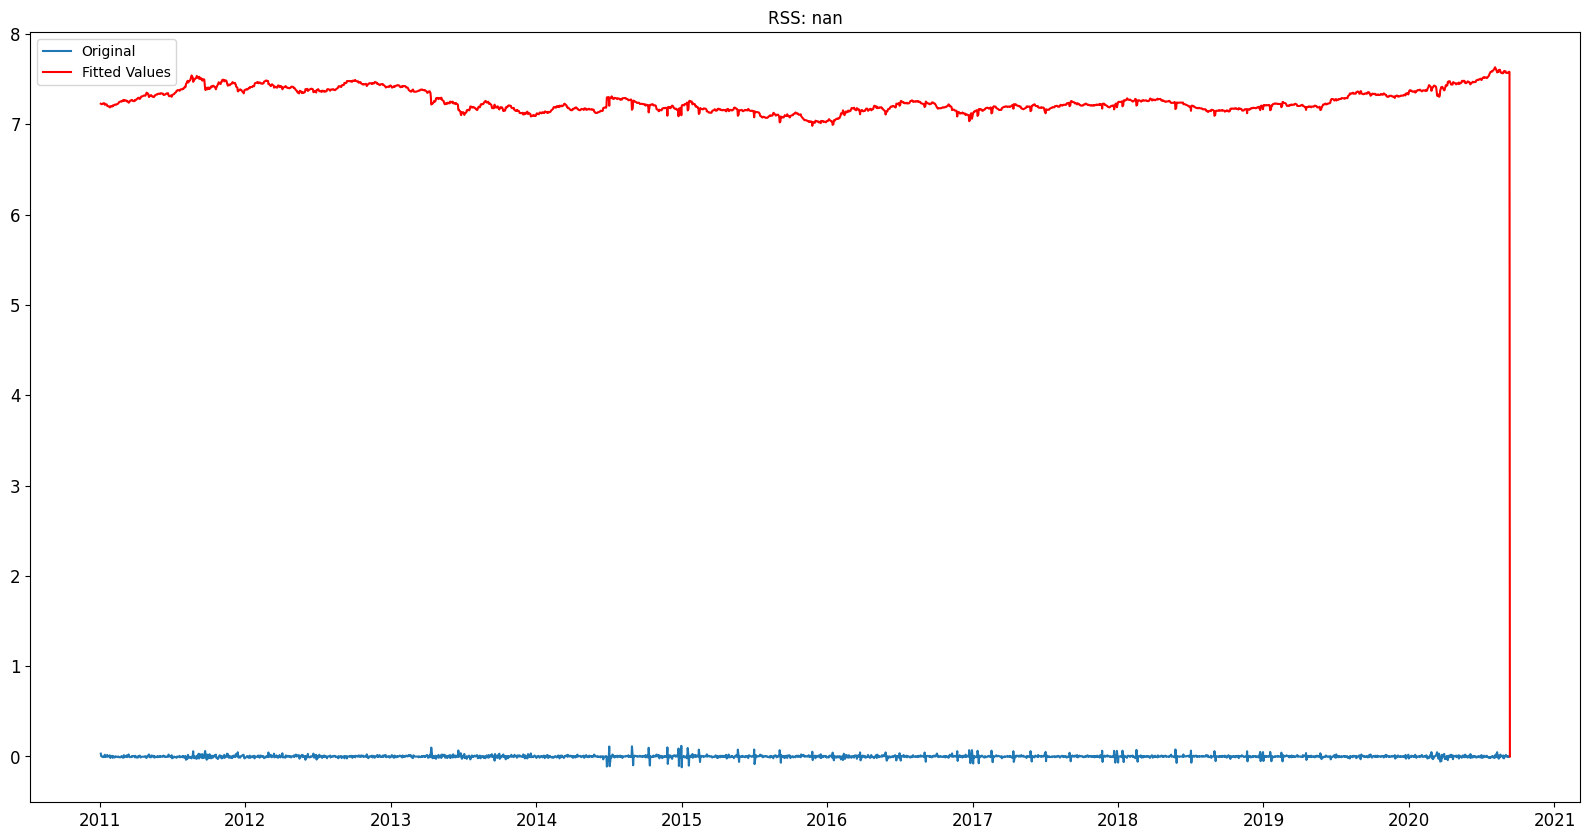

In [65]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# AR model
model = ARIMA(ts_log, order=(1, 1, 0))
results_AR = model.fit()

# Plotting the results
plt.figure(figsize=(20, 10))
plt.plot(ts_log_diff, label='Original')
plt.plot(results_AR.fittedvalues, color='red', label='Fitted Values')
plt.title('RSS: %.4f' % sum((results_AR.fittedvalues - ts_log_diff) ** 2))
plt.legend()
plt.show()


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsm

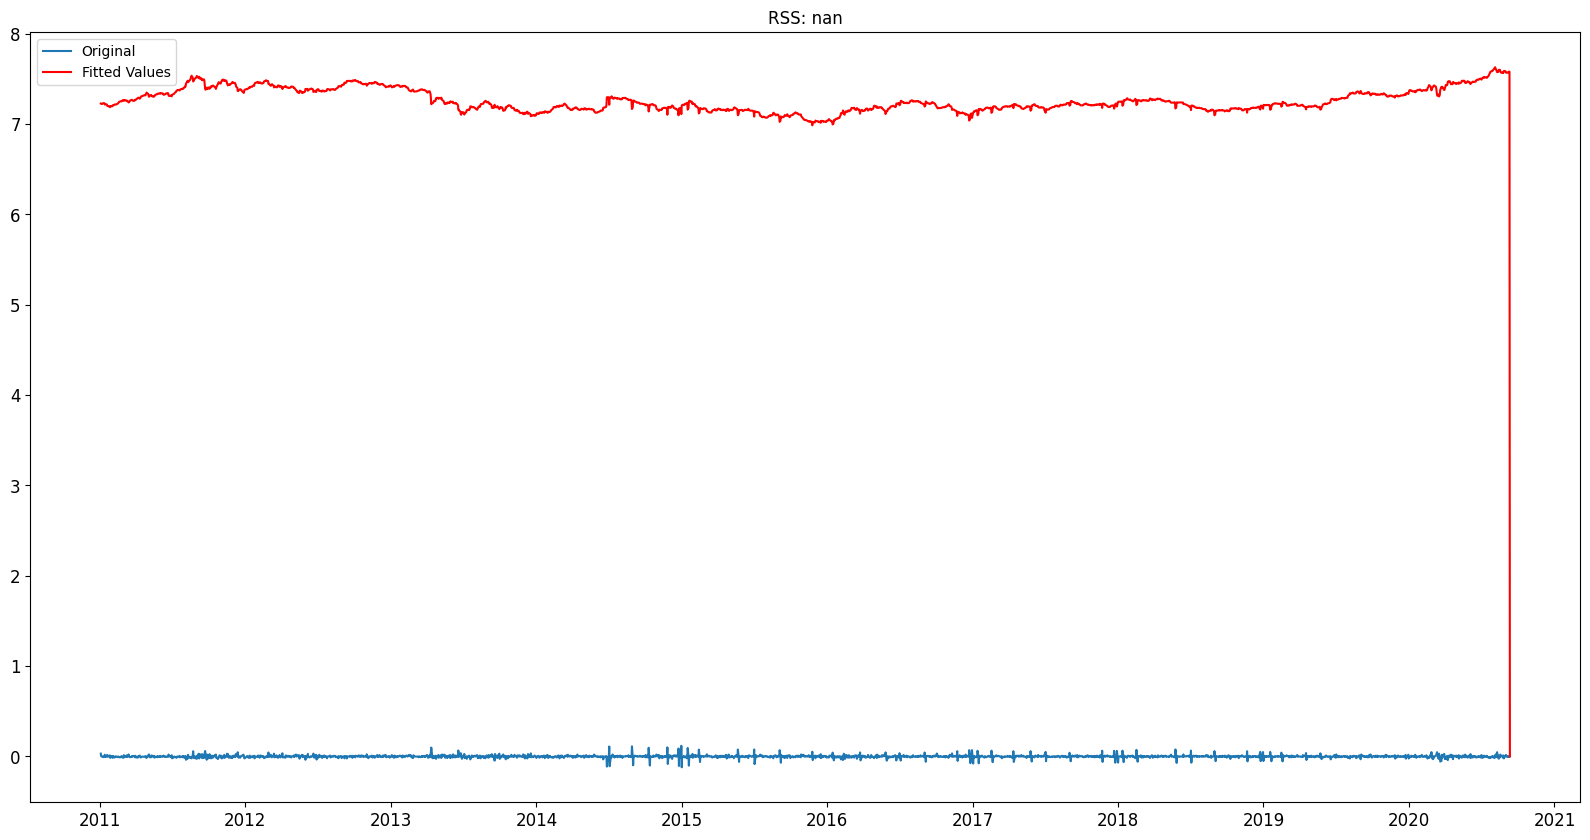

In [67]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# MA model
model = ARIMA(ts_log, order=(0, 1, 1))
results_MA = model.fit()

# Plotting the results
plt.figure(figsize=(20, 10))
plt.plot(ts_log_diff, label='Original')
plt.plot(results_MA.fittedvalues, color='red', label='Fitted Values')
plt.title('RSS: %.4f' % sum((results_MA.fittedvalues - ts_log_diff) ** 2))
plt.legend()
plt.show()


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsm

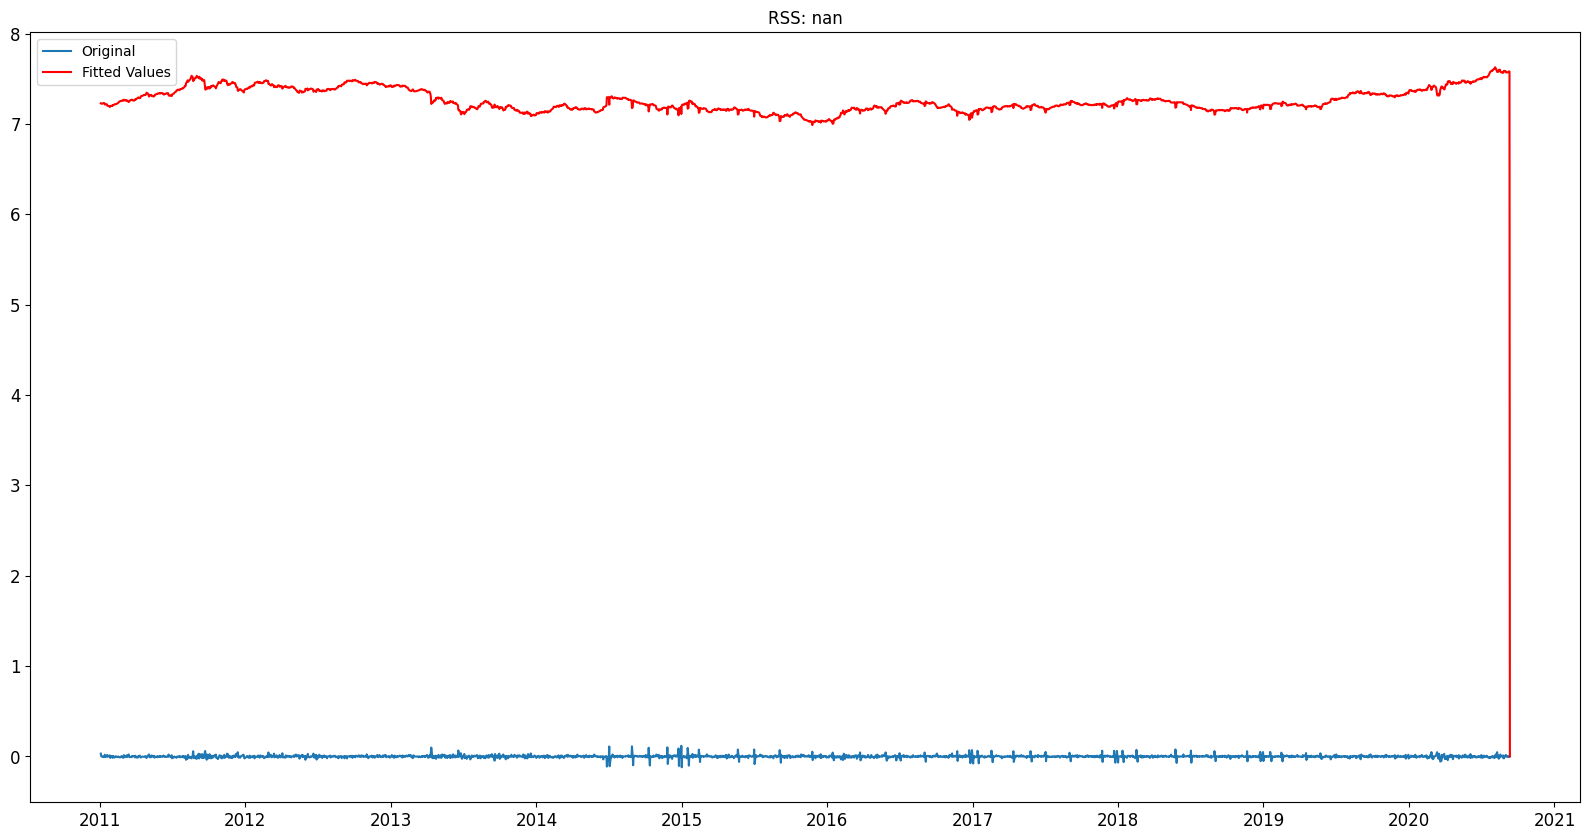

In [76]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Combined ARIMA model
model = ARIMA(ts_log, order=(1, 1, 1))
results_ARIMA = model.fit()

# Plotting the results
plt.figure(figsize=(20, 10))
plt.plot(ts_log_diff, label='Original')
plt.plot(results_ARIMA.fittedvalues, color='red', label='Fitted Values')
plt.title('RSS: %.4f' % sum((results_ARIMA.fittedvalues - ts_log_diff) ** 2))
plt.legend()
plt.show()


In [77]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print (predictions_ARIMA_diff.head())

Date
2020-09-11    0.000000
2020-09-10    7.579347
2020-09-09    7.582180
2020-09-08    7.578740
2020-09-07    7.573900
dtype: float64


In [78]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print (predictions_ARIMA_diff_cumsum.head())

Date
2020-09-11     0.000000
2020-09-10     7.579347
2020-09-09    15.161527
2020-09-08    22.740267
2020-09-07    30.314166
dtype: float64


In [79]:
predictions_ARIMA_log = pd.Series(ts_log.iloc[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

,0
Date,
2020-09-11,7.579347
2020-09-10,15.158694
2020-09-09,22.740874
2020-09-08,30.319614
2020-09-07,37.893513


In [80]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
predictions_ARIMA

,0
Date,
2020-09-11,1.957350e+03
2020-09-10,3.831219e+06
2020-09-09,7.520316e+09
2020-09-08,1.471096e+13
2020-09-07,2.863806e+16
...,...
2011-01-07,inf
2011-01-06,inf
2011-01-05,inf


In [83]:
import numpy as np
from sklearn.metrics import mean_absolute_error

# Ensure that predictions_ARIMA and the actual values have the same length
# Assuming predictions_ARIMA is for the test set, extract the corresponding test set from goldprice['Price']
test_size = len(predictions_ARIMA)
actual_test_values = goldprice['Price'][-test_size:]

# Now calculate the MAE
error = mean_absolute_error(actual_test_values, predictions_ARIMA)
print("MAE: %.3f" % error)

# Calculate RMSE
rmse = np.sqrt(np.mean((predictions_ARIMA - actual_test_values) ** 2))
print('RMSE: %.4f' % rmse)


MAE: 187318155507306782051480191768507153685797169349699122873278839050517062300428305502008118470599499836446180971429288009569965761633542258471206749652618469671162086367913128729614896374706006083596337619128525125434992288874323595563155506589158045996999135388649185681732255179979020629161765432008376320.000
RMSE: inf


Saving the predictions

In [85]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor().fit(X_train,y_train)
preds1 = rf_model.predict(X_test)
preds1

array([1280.193 , 1374.073 , 1344.464 , 1719.095 , 1330.2575, 1290.322 ,
       1142.758 , 1345.439 , 1265.819 , 1304.758 , 1713.282 , 1343.314 ,
       1361.444 , 1283.829 , 1571.714 , 1313.723 , 1334.002 , 1405.699 ,
       1524.442 , 1330.066 , 1754.894 , 1340.84  , 1415.928 , 1264.723 ,
       1328.3265, 1538.194 , 1750.115 , 1201.84  , 1593.015 , 1965.949 ,
       1355.739 , 1341.6765, 1679.31  , 1401.018 , 1321.546 , 1361.133 ,
       1588.2785, 1394.9385, 1649.926 , 1368.629 , 1194.987 , 1361.547 ,
       1427.017 , 1243.056 , 1312.657 , 1285.157 , 1627.973 , 1367.308 ,
       1443.882 , 1335.14  , 1282.66  , 1594.6665, 1354.989 , 1542.866 ,
       1444.81  , 1303.465 , 1272.255 , 1535.8885, 1265.5186, 1522.232 ,
       1373.475 , 1754.11  , 1753.118 , 1585.909 , 1346.269 , 1638.211 ,
       1247.906 , 1677.108 , 1551.7885, 1497.235 , 1627.759 , 1454.716 ,
       1589.018 , 1678.562 , 1570.1   , 1561.8025, 1232.288 , 1233.003 ,
       1324.6225, 1256.995 , 1358.082 , 1492.866 , 

In [86]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor().fit(X_train,y_train)
preds2 = xgb_model.predict(X_test)
preds2

array([1278.1401, 1371.271 , 1355.9695, 1723.461 , 1334.4335, 1297.1885,
       1143.4845, 1345.4817, 1261.3967, 1301.5546, 1712.7925, 1346.2677,
       1361.0388, 1280.0442, 1570.3239, 1307.7097, 1330.5502, 1405.5698,
       1528.4703, 1334.4691, 1751.9741, 1339.1648, 1416.658 , 1269.2885,
       1328.5906, 1542.5172, 1746.5859, 1201.6   , 1589.8477, 1968.6177,
       1368.1272, 1332.0349, 1681.0333, 1411.5604, 1321.3562, 1368.2838,
       1587.745 , 1392.7683, 1653.4155, 1365.9961, 1190.6746, 1366.0255,
       1425.8407, 1248.3562, 1309.78  , 1283.9656, 1634.9989, 1366.5922,
       1443.5984, 1332.3934, 1309.3379, 1592.4606, 1358.125 , 1543.663 ,
       1444.7942, 1301.2952, 1272.8468, 1533.4299, 1265.3164, 1530.9901,
       1368.8342, 1759.8955, 1754.0508, 1556.21  , 1344.388 , 1647.2428,
       1247.8563, 1674.9934, 1552.3225, 1503.549 , 1619.5886, 1457.717 ,
       1614.9015, 1673.7311, 1571.3754, 1561.7765, 1238.839 , 1240.098 ,
       1323.3727, 1261.1567, 1357.4338, 1501.3079, 

In [87]:
gold_price = pd.read_csv("/content/drive/MyDrive/GoldPrice.csv")

In [88]:
rf_predictions = pd.DataFrame()
rf_predictions['Predicted Price'] = preds1
rf_predictions

,Predicted Price
0,1280.1930
1,1374.0730
2,1344.4640
3,1719.0950
4,1330.2575
...,...
502,1182.8255
503,1812.5670
504,1247.1330
505,1574.3410


In [89]:
xgb_predictions = pd.DataFrame()
xgb_predictions['Predicted Price'] = preds2
xgb_predictions

,Predicted Price
0,1278.140137
1,1371.270996
2,1355.969482
3,1723.461060
4,1334.433472
...,...
502,1182.366333
503,1812.162109
504,1243.878052
505,1592.701172


In [93]:
rf_predictions.to_csv(r'/content/drive/MyDrive/RandomForest.csv',header=True,index=False)

In [94]:
xgb_predictions.to_csv(r'/content/drive/MyDrive/XGBoost predictions.csv',header=True,index=False)